# Mask R-CNN - Train on ScrANTon Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
'''
TensorFlow 2 gives: AttributeError: module 'tensorflow' has no attribute 'placeholder'
because MaskRCNN is using TF 1
So downgrade to 1 (default version in Colab is 2?)
'''
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
%%shell
#clone Mask_RCNN repo and install packages
#git clone https://github.com/matterport/Mask_RCNN
cd /content/drive/My\ Drive/Tracker/
#cd Mask_RCNN/
python setup.py install 

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling bu

# Mask R-CNN - Load Packages

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Tracker/")
os.chdir(ROOT_DIR)

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log
from mrcnn.model import log2_graph

from PIL import Image
import imageio
from ants import ants

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

VERION:  3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


Using TensorFlow backend.


## Configurations

In [5]:
tempConfig = ants.AntConfig()
ANT_DIR = os.path.join(ROOT_DIR, "data/ant")

In [6]:
class InferenceConfig(tempConfig.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5

    LEARNING_RATE = 0.1

AntConfig = InferenceConfig()
#AntConfig.display()

# Examine COCO Object

In [7]:
temp_antsCOCO = COCO(os.path.join(ANT_DIR, "antsCOCO_resized.json"))

loading annotations into memory...
Done (t=33.01s)
creating index...
index created!


In [8]:
maxDim = 0
minDim = 5000
for id in temp_antsCOCO.getImgIds():
  height = temp_antsCOCO.loadImgs(ids=[id])[0]['height']
  width = temp_antsCOCO.loadImgs(ids=[id])[0]['width']
  maxDim = max(maxDim,height,width)
  minDim = min(minDim,height,width)
print("Maximum Dimension: ",maxDim)
print("Minimum Dimension: ",minDim)

Maximum Dimension:  1024
Minimum Dimension:  1024


## Notebook Preferences

In [9]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
#TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Load the ants dataset to Mask R-CNN

In [10]:
class trainAntDataset(ants.AntDataset):

  def load_ant(self, dataset_dir, subset):
      """Load a subset of the ant dataset.
      dataset_dir: Root directory of the dataset.
      subset: Subset to load: train or val
      """
      antsCOCO = COCO(os.path.join(dataset_dir, "antsCOCO_resized.json"))
      
      # Add classes
      for i in antsCOCO.getCatIds():
          self.add_class("ScrANTonDataset", i, antsCOCO.loadCats(i)[0]["name"])
      
      # Add images
      for i in antsCOCO.getImgIds():
          if antsCOCO.loadAnns(antsCOCO.getAnnIds(imgIds=[i],catIds=antsCOCO.getCatIds())):
              self.add_image(
                      "ScrANTonDataset", image_id=i,
                      path = antsCOCO.imgs[i]['file_name'],#url['coco_url'],  #image = Image.open(urllib.request.urlopen(antsCOCO.imgs[i]['coco_url'])),
                      width=antsCOCO.imgs[i]["width"],
                      height=antsCOCO.imgs[i]["height"],
                      annotations=antsCOCO.loadAnns(antsCOCO.getAnnIds(imgIds=[i], catIds=antsCOCO.getCatIds())))

  def load_mask(self, image_id):
  
    """Generate instance masks for an image.
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    image_info = self.image_info[image_id]
    instance_masks = []
    class_ids = []
    annotations = self.image_info[image_id]["annotations"]
    # Build mask of shape [height, width, instance_count] and list
    # of class IDs that correspond to each channel of the mask.
    for annotation in annotations:
        class_id = annotation['category_id']    #self.map_source_class_id("{}".format(annotation['category_id']))
        if class_id:
            m = self.annToMask(annotation, image_info["height"],
                              image_info["width"])
            # Some objects are so small that they're less than 1 pixel area
            # and end up rounded out. Skip those objects.
            if m.max() < 1:
                continue
            # Is it a crowd? If so, use a negative class ID.
            if annotation['iscrowd']:
                # Use negative class ID for crowds
                class_id *= -1
                # For crowd masks, annToMask() sometimes returns a mask
                # smaller than the given dimensions. If so, resize it.
                if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                    m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
            instance_masks.append(m)
            class_ids.append(class_id)

    # Pack instance masks into an array
    if class_ids:
        mask = np.stack(instance_masks, axis=2).astype(np.bool)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids
    else:
        # Call super class to return an empty mask
        return super(AntDataset, self).load_mask(image_id)

  #def load_image(self,image_id):

  def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["coco_url"]
        #return self.image_info[image_id]["path"]

  def image_reference(self, image_id):
    """Return the path of the image."""
    info = self.image_info[image_id]
    if info["source"] == "ant":
        return info["path"]
    else:
        super(self.__class__, self).image_reference(image_id)

  def annToRLE(self, ann, height, width):
  
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """

    segm = ann['segmentation']
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = ann['segmentation']
    return rle

  def annToMask(self, ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = self.annToRLE(ann, height, width)
    m = maskUtils.decode(rle)
    return m

  def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = AntDataset()
    dataset_train.load_ant(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = AntDataset()
    dataset_val.load_ant(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

# Load Training Dataset

In [11]:
# Training dataset
dataset_train = trainAntDataset()#ants.AntDataset()
dataset_train.load_ant(ANT_DIR,'train')
dataset_train.prepare()

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


#Load Validation Dataset

In [12]:
# Validation dataset
dataset_val = trainAntDataset()#ants.AntDataset()
dataset_val.load_ant(ANT_DIR, "val")
dataset_val.prepare()

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


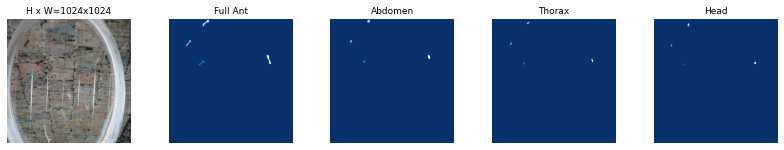

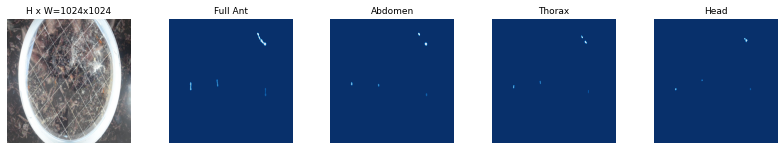

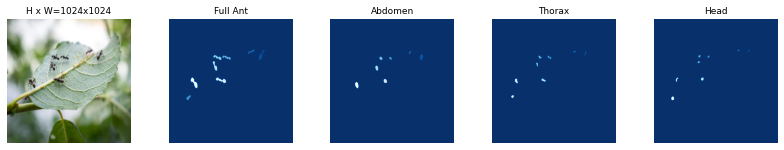

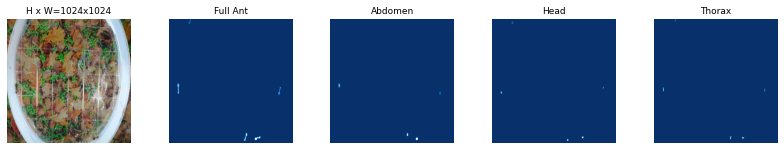

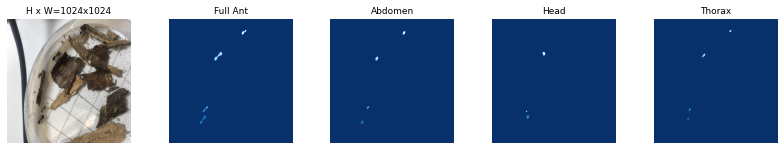

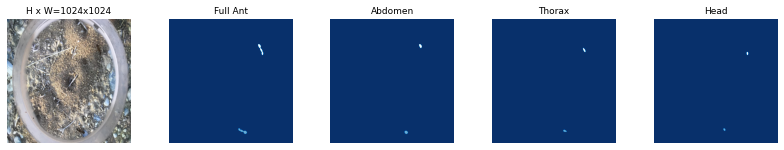

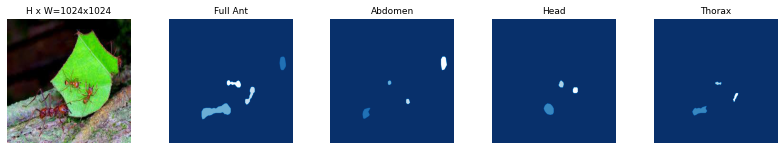

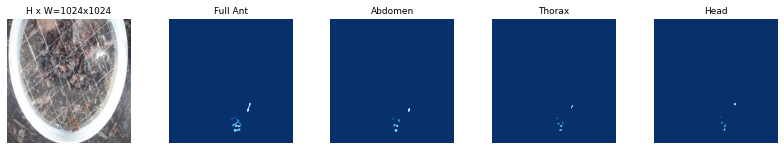

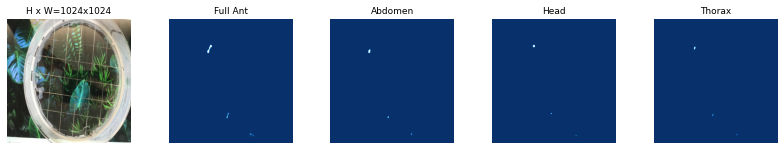

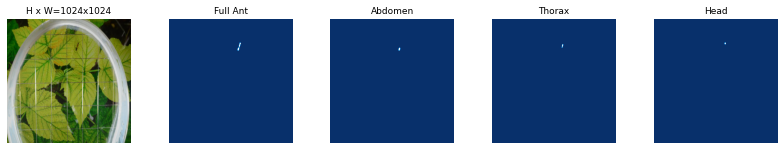

In [13]:
# Load and display random samples
os.chdir(ANT_DIR)
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=AntConfig, model_dir=MODEL_DIR)
model._get_distribution_strategy = None
model.keras_model.metrics_tensors = []
#model.keras_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
____________________________________

In [15]:
# Which weights to start with?
init_with = "custom"  # imagenet, coco, or last
init_model_path = os.path.join(ROOT_DIR, "logs/mask_rcnn_ants_0036.h5")

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

elif init_with == "custom":
    model.load_weights(init_model_path)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=AntConfig.LEARNING_RATE, 
            epochs=5,
            layers='heads')


Starting at epoch 0. LR=0.5

Checkpoint Path: /content/drive/My Drive/Tracker/logs/scrantondata20201103T1350/mask_rcnn_scrantondata_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
100/100 [==============================] - 4203s 42s/step - loss: nan - rpn_class_loss: nan - rpn_bbox_loss: nan - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.0068 - mrcnn_mask_loss: 0.0072 - val_loss: nan - val_rpn_class_loss: nan - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: nan - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00

Epoch 2/5
100/100 [==============================] - 4109s 41s/step - loss: nan - rpn_class_loss: nan - rpn_bbox_loss: nan - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: nan - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: nan - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/5
100/100 [==============================] - 4115s 41s/step - loss: nan - rpn_class_loss: nan - rpn_bbox_loss: nan - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: nan - val_rpn_class_loss: nan - val_rpn_bbox_los

In [17]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=AntConfig.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 5. LR=0.01

Checkpoint Path: /content/drive/My Drive/Tracker/logs/scrantondata20201103T1350/mask_rcnn_scrantondata_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

In [18]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
#model.keras_model.save_weights(model_path)

## Detection

In [33]:
class InferenceConfig(ants.AntConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "logs/mask_rcnn_ants_0036.h5")
#model_path = os.path.join(ROOT_DIR, "logs/TRAINEDFULLANTS824.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Tracker/logs/mask_rcnn_ants_0036.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1024.00000  int64
gt_class_id              shape: (12,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (12, 4)               min:  156.00000  max:  889.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  bool


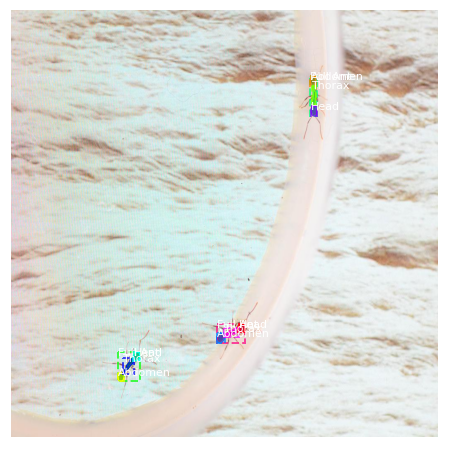

In [34]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[{'rois': array([[754, 488, 793, 562],
       [821, 252, 887, 310],
       [157, 719, 230, 737],
       [774, 490, 796, 512],
       [202, 721, 244, 737],
       [865, 254, 892, 273],
       [229, 719, 274, 744]], dtype=int32), 'class_ids': array([1, 1, 1, 2, 1, 2, 1], dtype=int32), 'scores': array([0.99783367, 0.9966899 , 0.9639532 , 0.9626293 , 0.734783  ,
       0.7145182 , 0.6483292 ], dtype=float32), 'masks': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...

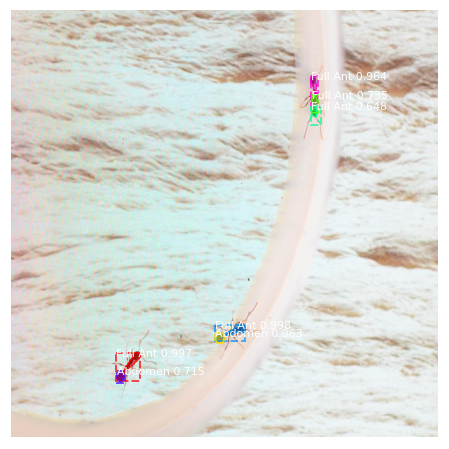

In [35]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [22]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array([], dtype=float32), 'masks': array([], shape=(1024, 1024, 0), dtype=float64)}]
[{'rois': array([], shape=(0, 4), dtype=int32), 'class_ids': array([], dtype=int32), 'scores': array